<a href="https://colab.research.google.com/github/kanru-wang/coursera_quantization_pruning_distillation/blob/main/Knowledge_Distillation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Knowledge Distillation
------------------------

1. Define a `Distiller` class with the custom logic for the distillation process
2. Train the `teacher` model which is a CNN that implements regularization via dropout
3. Train a `student` model (a smaller version of the teacher without regularization) by using knowledge distillation
4. Train another `student` model from scratch without distillation called `student_scratch`
5. Compare the three models


## Imports

In [1]:
# For setting random seeds
import os
os.environ['PYTHONHASHSEED']=str(42)

# Libraries
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import gc

# More random seed setup
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

## Prepare data

In [2]:
# Define train/test splits
splits = ['train[:80%]', 'train[80%:90%]', 'train[90%:]']

# Download the dataset
(train_examples, validation_examples, test_examples), info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True, split=splits)

# Print useful information
num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

print(f"There are {num_examples} images for {num_classes} classes.")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteHBRPOI/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.
There are 23262 images for 2 classes.


In [3]:
# Some global variables
pixels = 64
IMAGE_SIZE = (pixels, pixels)
BATCH_SIZE = 8  #32

# Apply resizing and pixel normalization
def format_image(image, label):
    image = tf.image.resize(image, IMAGE_SIZE) / 255.0
    return image, label

# Create batches of data
train_batches = train_examples.shuffle(num_examples // 4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = test_examples.map(format_image).batch(1)

## `Distiller` model

Need to override these methods:
- `compile`: Add some extra parameters
- `train_step`: Called during `model.fit`
- `test_step`: Call during `model.evaluate`

In [4]:
class Distiller(keras.Model):

  # Needs both the student and teacher models to create an instance of this class
  def __init__(self, student, teacher):
      super(Distiller, self).__init__()
      self.teacher = teacher
      self.student = student


  # Will be used when calling model.compile()
  def compile(self, optimizer, metrics, student_loss_fn,
              distillation_loss_fn, alpha, temperature):

      # Compile using the optimizer and metrics
      super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
      
      # Add the other params to the instance
      self.student_loss_fn = student_loss_fn
      self.distillation_loss_fn = distillation_loss_fn
      self.alpha = alpha
      self.temperature = temperature


  # Will be used when calling model.fit()
  def train_step(self, data):
      # Data is expected to be a tuple of (features, labels)
      x, y = data

      # Vanilla forward pass of the teacher
      # Note that the teacher is NOT trained
      teacher_predictions = self.teacher(x, training=False)

      # Use GradientTape to save gradients
      with tf.GradientTape() as tape:
          # Vanilla forward pass of the student
          student_predictions = self.student(x, training=True)

          # Compute vanilla student loss
          student_loss = self.student_loss_fn(y, student_predictions)
          
          # Compute distillation loss
          # Should be KL divergence between logits softened by a temperature factor
          distillation_loss = self.distillation_loss_fn(
              tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
              tf.nn.softmax(student_predictions / self.temperature, axis=1))

          # Compute loss by weighting the two previous losses using the alpha param
          loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

      # Use tape to calculate gradients for student
      trainable_vars = self.student.trainable_variables
      gradients = tape.gradient(loss, trainable_vars)

      # Update student weights 
      # Note that this done ONLY for the student
      self.optimizer.apply_gradients(zip(gradients, trainable_vars))

      # Update the metrics
      self.compiled_metrics.update_state(y, student_predictions)

      # Return a performance dictionary
      # You will see this being outputted during training
      results = {m.name: m.result() for m in self.metrics}
      results.update({"student_loss": student_loss, "distillation_loss": distillation_loss})
      return results


  # Will be used when calling model.evaluate()
  def test_step(self, data):
      # Data is expected to be a tuple of (features, labels)
      x, y = data

      # Use student to make predictions
      # Notice that the training param is set to False
      y_prediction = self.student(x, training=False)

      # Calculate student's vanilla loss
      student_loss = self.student_loss_fn(y, y_prediction)

      # Update the metrics
      self.compiled_metrics.update_state(y, y_prediction)

      # Return a performance dictionary
      # You will see this being outputted during inference
      results = {m.name: m.result() for m in self.metrics}
      results.update({"student_loss": student_loss})
      return results


## Teacher and student models

 `create_small_model` returns a simplified (number of layers and absence of regularization) version of the model that `create_big_model` returns

In [5]:
# Teacher model
def create_big_model():
    tf.random.set_seed(42)
    model = keras.models.Sequential([
        keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(64, 64, 3)),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(32, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Dropout(0.2),
        # keras.layers.Conv2D(64, (3, 3), activation='relu'),
        # keras.layers.MaxPooling2D((2, 2)),
        # keras.layers.Conv2D(128, (3, 3), activation='relu'),
        # keras.layers.MaxPooling2D((2, 2)),
        # keras.layers.Dropout(0.5),
        keras.layers.Flatten(),
        # keras.layers.Dense(512, activation='relu'),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(2)
    ])

    return model


# Student model
def create_small_model():
    tf.random.set_seed(42)
    model = keras.models.Sequential([
        keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(64, 64, 3)),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(2)
    ])

    return model

Notice that:
- The last layer does not have an softmax activation because the raw logits are needed for the knowledge distillation.
- Regularization via dropout layers will be applied to the teacher but NOT to the student. This is because the student should be able to learn this regularization through the distillation process.



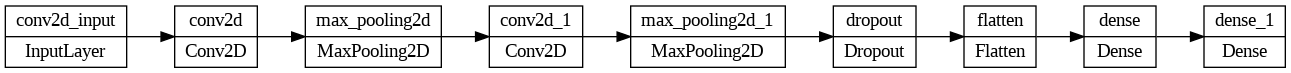

In [6]:
# Create the teacher
teacher = create_big_model()

# Plot architecture
keras.utils.plot_model(teacher, rankdir="LR")

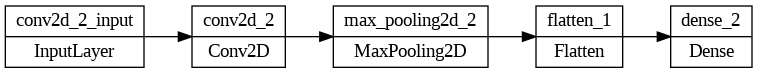

In [7]:
# Create the student
student = create_small_model()

# Plot architecture
keras.utils.plot_model(student, rankdir="LR")

Number of trainable parameters (weights and biases)

In [8]:
# Calculates number of trainable params for a given model
def num_trainable_params(model):
    return np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])


student_params = num_trainable_params(student)
teacher_params = num_trainable_params(teacher)

print(f"Teacher model has: {teacher_params} trainable params.\n")
print(f"Student model has: {student_params} trainable params.\n")
print(f"Teacher model is roughly {teacher_params//student_params} times bigger than the student model.")

Teacher model has: 205890 trainable params.

Student model has: 31202 trainable params.

Teacher model is roughly 6 times bigger than the student model.


In [9]:
gc.collect()

3765

### Train the teacher

Train for 4 epochs

In [10]:
# Compile the teacher model
teacher.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # Notice from_logits param is set to True
    optimizer=keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

# Fit the model and save the training history
teacher_history = teacher.fit(train_batches, epochs=4, validation_data=validation_batches)

Epoch 1/4
2327/2327 [==============================] - 38s 10ms/step - loss: 0.5915 - sparse_categorical_accuracy: 0.6803 - val_loss: 0.5531 - val_sparse_categorical_accuracy: 0.7081
Epoch 2/4
2327/2327 [==============================] - 29s 10ms/step - loss: 0.5046 - sparse_categorical_accuracy: 0.7505 - val_loss: 0.5083 - val_sparse_categorical_accuracy: 0.7481
Epoch 3/4
2327/2327 [==============================] - 29s 10ms/step - loss: 0.4539 - sparse_categorical_accuracy: 0.7857 - val_loss: 0.4791 - val_sparse_categorical_accuracy: 0.7726
Epoch 4/4
2327/2327 [==============================] - 29s 10ms/step - loss: 0.4028 - sparse_categorical_accuracy: 0.8120 - val_loss: 0.4848 - val_sparse_categorical_accuracy: 0.7700


## Train a student from scratch for reference

Train a student but without doing knowledge distillation. Train for only 3 epochs:

In [11]:
# Create student_scratch model with the same characteristics as the original student
student_scratch = create_small_model()

# Compile it
student_scratch.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

# Train and evaluate student trained from scratch
student_scratch_history = student_scratch.fit(train_batches, epochs=3, validation_data=validation_batches)

Epoch 1/3
2327/2327 [==============================] - 28s 9ms/step - loss: 0.6054 - sparse_categorical_accuracy: 0.6765 - val_loss: 0.5719 - val_sparse_categorical_accuracy: 0.7137
Epoch 2/3
2327/2327 [==============================] - 24s 9ms/step - loss: 0.5192 - sparse_categorical_accuracy: 0.7438 - val_loss: 0.5564 - val_sparse_categorical_accuracy: 0.7279
Epoch 3/3
2327/2327 [==============================] - 24s 9ms/step - loss: 0.4692 - sparse_categorical_accuracy: 0.7810 - val_loss: 0.5928 - val_sparse_categorical_accuracy: 0.7248


## Knowledge Distillation

Train for only 3 epochs

In [12]:
# Create Distiller instance
distiller = Distiller(student=student, teacher=teacher)

# Compile Distiller model
distiller.compile(
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.05,
    temperature=5,
)

# Distill knowledge from teacher to student
distiller_history = distiller.fit(train_batches, epochs=3, validation_data=validation_batches)

Epoch 1/3
2327/2327 [==============================] - 27s 9ms/step - sparse_categorical_accuracy: 0.6865 - student_loss: 0.5904 - distillation_loss: 0.0151 - val_sparse_categorical_accuracy: 0.6857 - val_student_loss: 0.4461
Epoch 2/3
2327/2327 [==============================] - 32s 11ms/step - sparse_categorical_accuracy: 0.7468 - student_loss: 0.5125 - distillation_loss: 0.0096 - val_sparse_categorical_accuracy: 0.7373 - val_student_loss: 0.5316
Epoch 3/3
2327/2327 [==============================] - 28s 10ms/step - sparse_categorical_accuracy: 0.7739 - student_loss: 0.4713 - distillation_loss: 0.0084 - val_sparse_categorical_accuracy: 0.7034 - val_student_loss: 0.3791


## Comparing the models


In [13]:
# Compute accuracies
student_scratch_acc = student_scratch.evaluate(test_batches, return_dict=True).get("sparse_categorical_accuracy")
distiller_acc = distiller.evaluate(test_batches, return_dict=True).get("sparse_categorical_accuracy")
teacher_acc = teacher.evaluate(test_batches, return_dict=True).get("sparse_categorical_accuracy")

# Print results
print(f"\n\nTeacher achieved a sparse_categorical_accuracy of {teacher_acc*100:.2f}%.\n")
print(f"Student with knowledge distillation achieved a sparse_categorical_accuracy of {distiller_acc*100:.2f}%.\n")
print(f"Student without knowledge distillation achieved a sparse_categorical_accuracy of {student_scratch_acc*100:.2f}%.\n")

2326/2326 [==============================] - 8s 3ms/step - loss: 0.4607 - sparse_categorical_accuracy: 0.7799


Teacher achieved a sparse_categorical_accuracy of 77.99%.

Student with knowledge distillation achieved a sparse_categorical_accuracy of 73.77%.

Student without knowledge distillation achieved a sparse_categorical_accuracy of 73.52%.



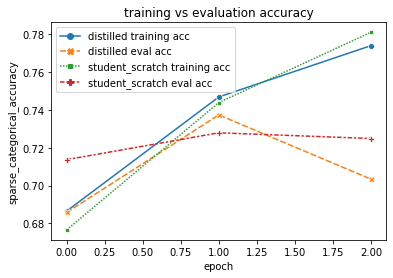

In [14]:
# Get relevant metrics from a history
def get_metrics(history):
    history = history.history
    acc = history['sparse_categorical_accuracy']
    val_acc = history['val_sparse_categorical_accuracy']
    return acc, val_acc


# Plot training and evaluation metrics given a dict of histories
def plot_train_eval(history_dict):
  
    metric_dict = {}

    for k, v in history_dict.items():
        acc, val_acc= get_metrics(v)
        metric_dict[f'{k} training acc'] = acc
        metric_dict[f'{k} eval acc'] = val_acc

    acc_plot = pd.DataFrame(metric_dict)
    
    acc_plot = sns.lineplot(data=acc_plot, markers=True)
    acc_plot.set_title('training vs evaluation accuracy')
    acc_plot.set_xlabel('epoch')
    acc_plot.set_ylabel('sparse_categorical_accuracy')
    plt.show()


# Plot for comparing the two student models
plot_train_eval({
    "distilled": distiller_history,
    "student_scratch": student_scratch_history,
})